### First we define a Decision Tree.
#### A Decision Tree is initialized with some training data and testing data, as well as a list of discrete-valued attributes that each observation will have.

In [2]:
# Let us first define what it means to be a discrete-valued attribute - each observation will have a list of these items
from typing_extensions import Self


class Attribute:
    """An attribute is defined by its set of possible values
    """
    
    def __init__(self, values: set[int]):
        """Initialize an Attribute object

        Args:
            values (set[int]): set of all possible assignments for any instance of this attribute
        """
        self.__values = values
        
    def contains_option(self, v: int) -> bool:
        """Helper method to determine if this attribute has the input value as an option (e.g. - a binary attribute will not have 2 or a greater number as a possible value)

        Args:
            v (int): value in question 

        Returns:
            bool: whether the value is a possible option for this Attribute
        """
        return v in self.__values
    
        
class AttributeInstance:
    """When an observation is created, it will be a given a list of Attributes, and a list of AttributeInstances - a value for said attribute
    """       
    
    def __init__(self, attribute: Attribute, value: int):
        """Create an Attribute Instance object, which needs to know what attribute it is an instance of, and its assignment

        Args:
            attribute (Attribute): The underlying attribute with its list of possible values
            value (int): Value assigned to this particular attribute instance
        """
        assert attribute.contains_option(value)
        self.__attribute = attribute
        self.__value = value
        
    def get_value(self, attribute: Attribute) -> int:
        """If the attribute matches this attribute instance's underlying attribute, return this instance's associated value

        Args:
            v (int): Value to compare to this AttributeInstance's value
        """
        if self.__attribute == attribute:
            return self.__value
        else:
            return None
    
    
class Observation:
    """An Observation will have a list of attributes and an equally long list of attribute instances
    """
    
    def __init__(self, classification: int, attributes: list[Attribute], values: list[int]):
        """Create an observation with its list of attributes and its list of corresponding values for each attribute

        Args:
            classification (int): Classification for this observation
            attributes (list[Attribute]): List of attributes which apply to this observation
            values (list[AttributeInstance]): List of this observation's values for each of the attributes
        """
        self.__classification = classification
        self.attributes = attributes
        self.__values = [AttributeInstance(attribute=attr, value=v) for attr,v in zip(attributes, values)]
        
    def get_class(self) -> int:
        """Return the class of this observation

        Returns:
            int: this observation's class
        """
        return self.__classification
        
    def get_value(self, attribute: Attribute) -> tuple[int, AttributeInstance]:
        """For the given attribute, return its value for this observation

        Args:
            attribute (Attribute): attribute whose value we want for this observation

        Returns:
            int: value for 
        """
        for attr_inst in self.__values:
            if attr_inst.get_value(attribute=attribute) != None:
                return (attr_inst.get_value(attribute=attribute), attr_inst)
        return None
    
    @staticmethod
    def partition(observations: list[Self], attribute: Attribute) -> list[list[Self]]:
        """Class method that - given a list of observations, partition them by their value of the given attribute
        """
        result = []
        seen = {}
        for observation in observations:
            v = observation.get_value(attribute)[0]
            if v in seen.keys():
                # Grab the list of observations associated with this value, and append this observation to it
                result[seen[v]].append(observation)
            else:
                seen[v] = len(result)
                result.append([observation])
        
        return result    

In [3]:
# We need to create a decision tree which - given a list of training Observations - produces a decision tree that will predict classes of unseen Observations
import math
from xmlrpc.client import MAXINT

class DecisionTree:
    """This will essentially be a wrapper for a tree node class - the node will do all the work
    """
    
    class DecisionTreeNode:
        """An inner class to help make decisions for observations based on attributes
        """
        
        def __init__(self, observations: list[Observation], attributes: list[Attribute], use_gini_index: bool=False):
            """Initialize a DecisionTreeNode with a given list of observations and attributes the data needs to be split on

            Args:
                observations (list[Observation]): observations, each of which have values for each attribute in attributes
                attributes (list[Attribute]): list of attributes the data still needs to be split on
            """
            self.__gini_index = use_gini_index
            self.__default_prediction = None
            self.__children = {}
            self.__attribute_to_split_on = None
            # First check of all predictions are of the same class
            classes = set([observation.get_class() for observation in observations])
            if len(classes) == 1:
                self.__default_prediction = observations[0].get_class()
            else:
                # See which attribute is the most valuable to split on
                # That attribute will lead to the highest information gain
                current_entropy = self.__calculate_entropy([observations])
                record_information_gain = float('-inf')
                for attribute in attributes:
                    categories = Observation.partition(observations=observations, attribute=attribute)
                    # Calculate the entropy associated with this partitioning of elements
                    partition_entropy = self.__calculate_entropy(partition=categories)
                    # This gives us the information gain, which we want to maximize
                    information_gain = current_entropy - partition_entropy
                    if information_gain > record_information_gain:
                        # Lower node impurity is good and leads to a higher information gain
                        record_information_gain = information_gain
                        self.__attribute_to_split_on = attribute
                        
                if self.__attribute_to_split_on:
                    # We did have attributes to split on
                    categories = Observation.partition(observations=observations, attribute=self.__attribute_to_split_on)
                    new_attributes = [attribute for attribute in attributes if attribute != self.__attribute_to_split_on]
                    for group_class in categories:
                        attribute_to_split_on_value = group_class[0].get_value(attribute=self.__attribute_to_split_on)[0]
                        # Each tuple has a list of observations and the value for the split-on attribute for each list
                        self.__children[attribute_to_split_on_value] = DecisionTree.DecisionTreeNode(observations=group_class, attributes=new_attributes, use_gini_index=self.__gini_index)
                else:
                    # Then we  have no attributes to branch on so go by majority classification
                    counts = {}
                    record_information_gain = 0
                    for observation in observations:
                        classification = observation.get_class()
                        if classification in counts.keys():
                            counts[classification] += 1
                        else:
                            counts[classification] = 1
                        if counts[classification] > record_information_gain:
                            record_information_gain = counts[classification]
                            self.__default_prediction = classification
                    
        def __calculate_entropy(self, partition: list[list[Observation]]) -> float:
            """Given a partition set of observations with respect to some attribute, return the value of said attribute

            Args:
                partition (list[tuple[list[Observation], AttributeInstance]]): Each tuple corresponds to a list of observations which share the same value for the partitioned attribute

            Returns:
                float: value associated with this partition of observations
            """
            result = 0
            n = sum([len(family) for family in partition])
            for family in partition:
                # Each family has a different value for whatever attribute split created the partition
                family_probability = len(family) / n
                class_counts = {}
                family_entropy = 0
                for observation in family:
                    classification = observation.get_class()
                    if classification in class_counts.keys():
                        class_counts[classification] += 1
                    else:
                        class_counts[classification] = 1
                for count in class_counts.values():
                    # Each occurence 
                    probability = count / len(family)
                    # Add to node impurity depending on gini index or entropy calculation
                    family_entropy -= probability*(1-probability) if self.__gini_index else probability*math.log2(probability)
                result += family_probability * family_entropy
            return result
                        
        def predict(self, observation: Observation) -> int:
            """Predict the value of an unseen testing observation

            Args:
                observation (Observation): observation whose class we want to predict

            Returns:
                int: predicted classification for said observation
            """
            if len(self.__children) == 0:
                # This is a node where we went with a default prediction value because we have no attributes to split or all observations in training were of the same class
                return self.__default_prediction
            else:
                # Go to the subtree which corresponds to the observation's value for whatever attribute was deemed most valuable to split on for this node
                attribute_split_value = observation.get_value(attribute=self.__attribute_to_split_on)[0]
                if attribute_split_value not in self.__children.keys():
                    # This testing instance's observation value was never seen in training - so go with the closes value seen in training
                    record = MAXINT
                    record_close_value = MAXINT
                    for seen_split_value in self.__children.keys():
                        if abs(attribute_split_value - seen_split_value) < record:
                            record = abs(attribute_split_value - seen_split_value)
                            record_close_value = seen_split_value
                    attribute_split_value = record_close_value
                return self.__children[attribute_split_value].predict(observation=observation)
                
    
    def __init__(self, observations: list[Observation], gini_index: bool=False):
        """Create a decision tree based on the observations

        Args:
            observations (list[Observation]): list of observations that will define our tree
        """
        self.__root = DecisionTree.DecisionTreeNode(observations = observations, attributes = observations[0].attributes, use_gini_index=gini_index)
    
    
    def predict(self, observation: Observation) -> int:
        """Predict the classification of the given observation by having its underlying node do all the work

        Args:
            observation (Observation): observation whose class we want to predict

        Returns:
            int: prediction class of the inputted observation
        """
        return self.__root.predict(observation=observation)
    
    def display_results(self, population: list[Observation], population_label: str):
        true_values = [observation.get_class() for observation in population]
        predicted_values = [self.__root.predict(observation=observation) for observation in population]
        accuracy = sum([1 for i in range(len(true_values)) if true_values[i] == predicted_values[i]]) / len(true_values)
        print(f"{population_label} Accuracy: {100*accuracy}%")   

### Let us implement the reading of observations from a file.

In [4]:
import random
import matplotlib.pyplot as plt

class FileObservationsReader:
    """This class takes in data as a pandas data frame along with a block size and parameter for the k nearest neighbors, 
    """
    
    def __init__(self, file_name: str, delimiter: str, id_column_name: str, classification_column_name: str, continuous_splits: int = 4, gini_index: bool=False):
        """Initialize a FileObservationsReader, which creates a list of observations from the given file
        Args:
            file_name (str): The file from which to read in data
            k (int): The number of closest other points used to guess if a certain point belongs to a given classification
            n (int): The number of different blocks to partition the training points into
        """
        # First let's read in our data
        read_from = open(file_name, "r")
        points_as_strings = read_from.readlines()

        # Let's look at the first line, which reveals the point attributes which are numeric
        header = points_as_strings[0][:-1] # Remember to omit the '\n' character
        attributes = header.split(delimiter)
        class_idx = -1
        id_idx = -1
        attribute_name_indices = []
        # For each attribute, store its value for all observations
        attribute_values = {}
        for i, attr in enumerate(attributes):
            if attr == classification_column_name:
                class_idx = i
            elif attr == id_column_name:
                id_idx = i
            else:
                attribute_name_indices.append(i)
                attribute_values[i] = []
        points_as_strings = points_as_strings[1:]
        read_from.close()
        
        unique_labels = set()
        labels = []
        names = []
        for point_string in points_as_strings:
            # First omit the '\n' character in each row of data corresponding to a point
            # Get a list of strings, each corresponding to an attribute of the point
            point_attributes = point_string[:-1].split(delimiter)

            # Record the unique name and class of this point, and keep track of all the different classes we have seen
            labels.append(int(point_attributes[class_idx]))
            unique_labels.add(int(point_attributes[class_idx]))
            names.append(point_attributes[id_idx])

            # Record all attribute elements of the points 
            for idx in attribute_name_indices:
                attribute_values[idx].append(point_attributes[idx])
                
        # We need to look through each of the attribute value sets, and see which are continuous
        # The first value will do:
        #   If it is an integer, assume discrete unless we are corrected
        #   If it is a float, assume continuous
        #   If it is a string, assume discrete
        discrete_integer_attribute_indices = set() # Column indices of all discrete integer attributes
        continuous_attribute_indices = set() # Column indices of all continuous attributes
        discrete_named_attribute_indices = set() # Column indices of all discrete named attributes
        for idx, values in attribute_values.items():
            for i, string in enumerate(values):
                if i > 0:
                    # The only thing we need to check is if all integer attributes are still integers
                    if not string.isdigit() and idx in discrete_integer_attribute_indices:
                        # No longer a discrete integer attribute
                        discrete_integer_attribute_indices.remove(idx)
                        continuous_attribute_indices.add(idx)
                        break
                else:
                    if string.isdigit():
                    # Discrete integer attribute MAYBE
                        discrete_integer_attribute_indices.add(idx)
                    # See if it is a float - otherwise it is some discrete attribute
                    else:
                        try:
                            # Is a float
                            float(string)
                            continuous_attribute_indices.add(idx)
                        except:
                            # Not a float
                            discrete_named_attribute_indices.add(idx)
        
        # Map index to list of values each observation takes on
        discrete_attribute_values = {} # List for all observations in the file
        possible_discrete_attribute_values = {} # Keep track of the unique values for each attribute that occur
        for attr_idx in discrete_integer_attribute_indices:
            discrete_attribute_values[attr_idx] = []
            possible_discrete_attribute_values[attr_idx] = set()
            for point_string in points_as_strings:
                point_attributes = point_string[:-1].split(delimiter)
                discrete_attribute_values[attr_idx].append(int(point_attributes[attr_idx]))
                possible_discrete_attribute_values[attr_idx].add(int(point_attributes[attr_idx]))
                
        # We will do something similar for the continuous attribute, but we need to discretize...
        continuous_attribute_values = {} # List for all observations in the file
        possible_continuous_attribute_values = {} # Each continuous attribute will be discretized into 4 different classes
        for attr_idx in continuous_attribute_indices:
            continuous_attribute_values[attr_idx] = []
            possible_continuous_attribute_values[attr_idx] = set(range(continuous_splits))
            for point_string in points_as_strings:
                point_attributes = point_string[:-1].split(delimiter)
                continuous_attribute_values[attr_idx].append(float(point_attributes[attr_idx]))
        # Next we should normalize and then discretize the continuous attributes
        def classify(x: float) -> int:
            """Depending on the value of a float - between 0 and 1 - give one of four discrete classifications

            Args:
                x (float): the float to classify

            Returns:
                int: the classification of said float
            """
            discrete_class_width = 1 / continuous_splits
            return int(x / discrete_class_width)
        # Normalize a vector
        def normalize(x: list[float]):
            """Helper method to normalize a vector (treated as a list)

            Args:
                x (list[float]): vector to normalize - putting all values between 0 and 1
            """
            u = max(x)
            l = min(x)
            for idx, v in enumerate(x):
                x[idx] = (v - l) / (u - l)
        # Use those functions to discretize
        for attr_idx in continuous_attribute_values.keys():
            normalize(continuous_attribute_values[attr_idx])
            continuous_attribute_values[attr_idx] = [classify(x) for x in continuous_attribute_values[attr_idx]]
            
        # Finally we will handle the attributes which have string values - which are therefore discrete attributes
        discrete_named_attribute_values = {} # dict[int, list[string]], but will SOON become dict[int, list[int]] via the next variable...
        possible_discrete_named_attribute_values = {} # dict[int, dict[string, int]]
        for attr_idx in discrete_named_attribute_indices:
            discrete_named_attribute_values[attr_idx] = []
            possible_discrete_named_attribute_values[attr_idx] = {}
            for point_string in points_as_strings:
                point_attributes = point_string[:-1].split(delimiter)
                str_value = point_attributes[attr_idx]
                discrete_named_attribute_values[attr_idx].append(str_value)
                # map that string to an integer
                possible_discrete_named_attribute_values[attr_idx][str_value] = len(possible_discrete_named_attribute_values[attr_idx])
        # Now turn the named discrete attributes into integers
        for attr_idx, names in discrete_named_attribute_values.items():
            for idx, name in enumerate(names):
                # Map this name to a number
                discrete_named_attribute_values[attr_idx][idx] = possible_discrete_named_attribute_values[attr_idx][name]
                    
        # Now we can create our list of attributes, and all possible values for said attributes
        #   discrete_attribute_values - dict[int, list[int]]
        #   continuous_attribute_values - dict[int, list[int]]
        #   discrete_named_attribute_values - dict[int, list[int]]
        # Combine those three dictionaries into one dictionary
        attribute_values = {} # Values of each attribute for all observations (mapped by column index)
        possible_attribute_values = {} # All possible values of each attribute (mapped by column index)
        for attr_idx, values in discrete_attribute_values.items():
            attribute_values[attr_idx] = values
            possible_attribute_values[attr_idx] = set(values)
        for attr_idx, values in continuous_attribute_values.items():
            attribute_values[attr_idx] = values
            possible_attribute_values[attr_idx] = set(values)
        for attr_idx, values in discrete_named_attribute_values.items():
            attribute_values[attr_idx] = values
            possible_attribute_values[attr_idx] = set(values)
        # attribute_values - dict[int, list[int]]
        # possible_attribute_values - dict[int, set[int]]

        # Now we are ready to create a list of observations
        self.__observations = []
        # Make an Attribute object for each attribute from the data
        attributes = [Attribute(values = possible_attribute_values[i]) for i in possible_attribute_values.keys()]
        for idx in range(len(points_as_strings)):
            observation_values = [attribute_values[col][idx] for col in attribute_values.keys()]
            self.__observations.append(Observation(classification=labels[idx], attributes=attributes, values=observation_values))
        
        # Break up data into training and testing...
        n = len(self.__observations)
        train_size = (n * 8) // 10
        training_indices = set(random.sample(population=range(n), k=train_size))
        test_indices = set([i for i in range(n) if i not in training_indices])
        self.__train_population = [self.__observations[i] for i in training_indices]
        self.__test_population = [self.__observations[i] for i in test_indices]
        
        # Make a decision tree
        self.__decision_tree = DecisionTree(observations=self.__train_population, gini_index=gini_index)
              
    def display_results(self):
        """Helper method to display the underlying decision tree's performance
        """
        self.__decision_tree.display_results(population=self.__train_population, population_label="Training")
        self.__decision_tree.display_results(population=self.__test_population, population_label="Testing")      
            
    def plot_predictions(self):
        # If we do not have two-dimensional data, do not plot
        if len(self.__observations) < 1 or len(self.__observations[0].attributes) != 2:
            return
        
        # Plot our data with its actual classifications
        self.__plot_data(population=self.__train_population, training_or_testing="Training")
        self.__plot_data(population=self.__test_population, training_or_testing="Testing")
        
        # Plot our predictions
        self.__plot_predictions(population=self.__train_population, training_or_testing="Training")
        self.__plot_predictions(population=self.__test_population, training_or_testing="Testing")
        
    def __plot_data(self, population: list[Observation], training_or_testing: str):
        """Helper method to plot a list of observations

        Args:
            population (list[Observation]): the list of observations to plot - each of which had better have two attributes or this method should not have been called
        """
        fig, ax = plt.subplots()
        first_attribute = self.__observations[0].attributes[0]
        second_attribute = self.__observations[0].attributes[1]
        X = [observation.get_value(first_attribute)[0] for observation in population]
        Y = [observation.get_value(second_attribute)[0] for observation in population]
        classifications = [observation.get_class() for observation in population]
        scatter = ax.scatter(X, Y, c=classifications)
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        legend = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend)
        plt.title(f"Actual {training_or_testing} Data:")
        plt.xlabel("Attribute 1 Value")
        plt.ylabel("Attribute 2 Value")
        plt.show()
        fig.clear()
        
    def __plot_predictions(self, population: list[Observation], training_or_testing: str):
        """Helper method to plot the predictions of a population

        Args:
            population (list[Observation]): list of observations we want to predict
        """
        fig, ax = plt.subplots()
        first_attribute = self.__observations[0].attributes[0]
        second_attribute = self.__observations[0].attributes[1]
        X = [observation.get_value(first_attribute)[0] for observation in population]
        Y = [observation.get_value(second_attribute)[0] for observation in population]
        classifications = [self.__decision_tree.predict(observation=observation) for observation in population]
        scatter = ax.scatter(X, Y, c=classifications)
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        legend = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend)
        plt.title(f"Model Prediction for {training_or_testing} Data:")
        plt.xlabel("Attribute 1 Value")
        plt.ylabel("Attribute 2 Value")
        plt.show()
        fig.clear()

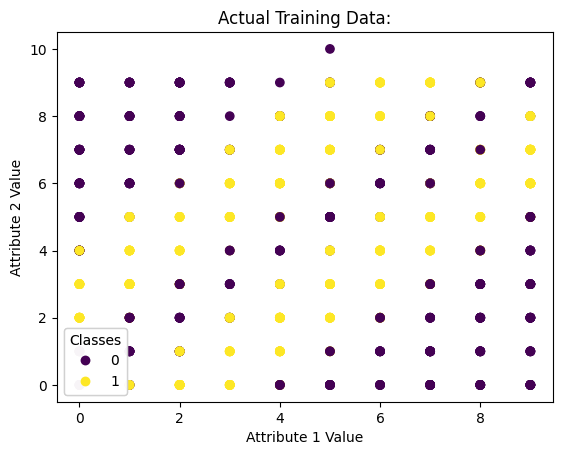

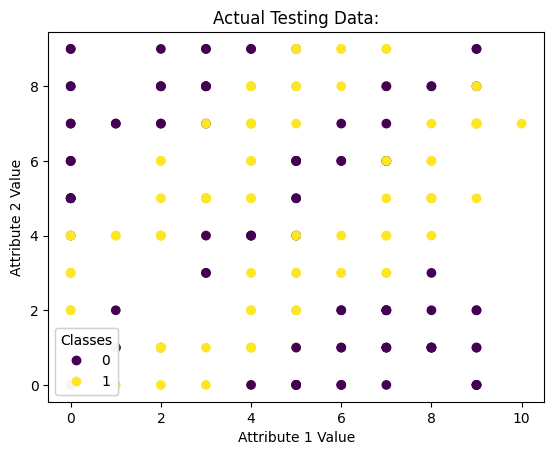

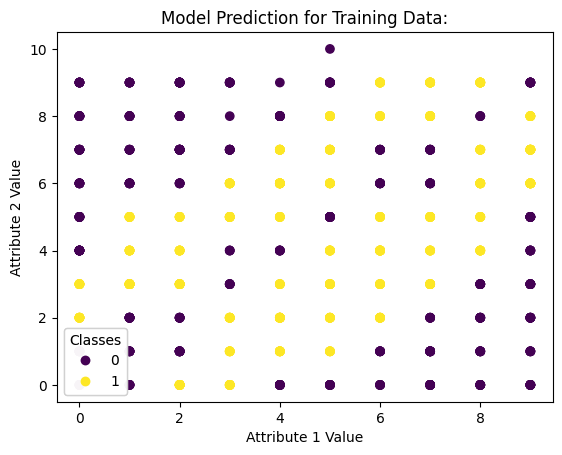

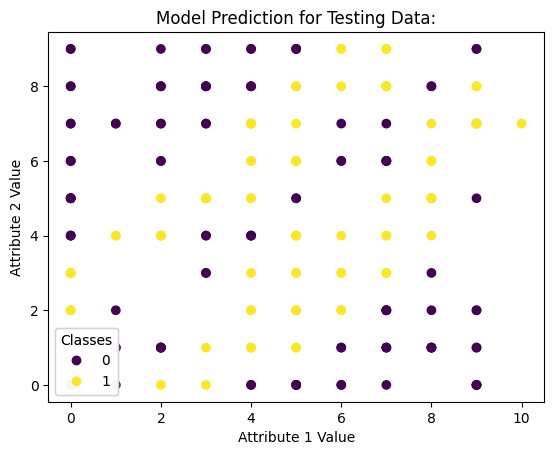

Training Accuracy: 88.5%
Testing Accuracy: 84.5%


In [5]:
# Let us display prediction results from the labeled-examples file
fobsr = FileObservationsReader(file_name="labeled-examples", delimiter=" ", id_column_name="id", classification_column_name="class", continuous_splits=10)
fobsr.plot_predictions()
fobsr.display_results()

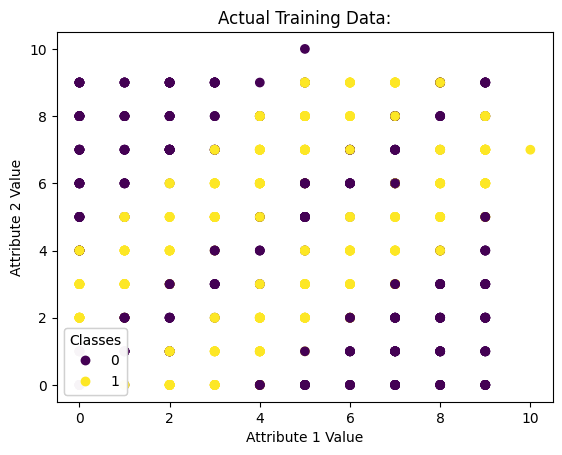

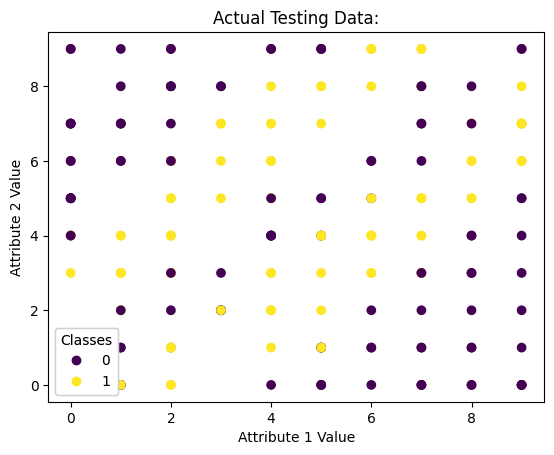

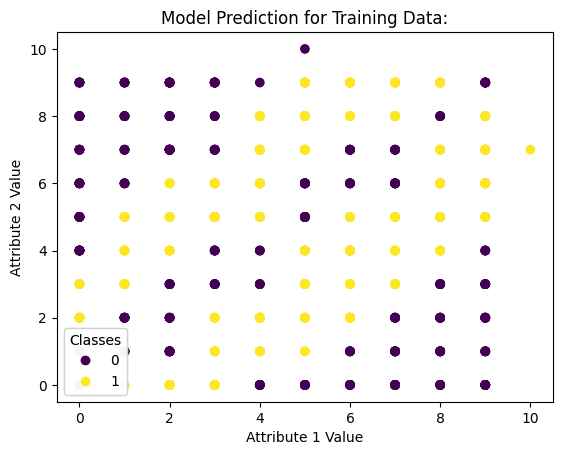

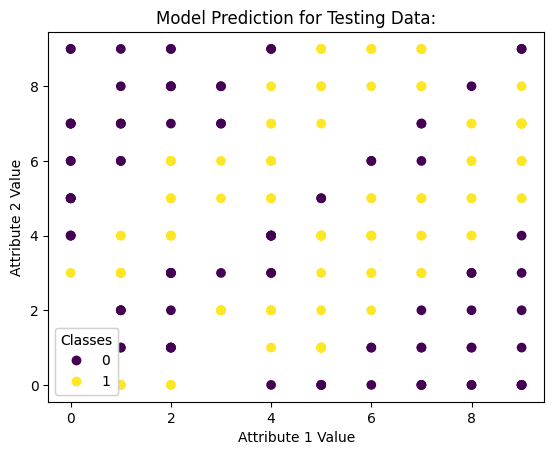

Training Accuracy: 90.125%
Testing Accuracy: 80.5%


In [6]:
fobsr = FileObservationsReader(file_name="labeled-examples", delimiter=" ", id_column_name="id", classification_column_name="class", continuous_splits=10, gini_index=True)
fobsr.plot_predictions()
fobsr.display_results()

In [7]:
# Now we will display prediction results from the winequality.csv files
fobsr = FileObservationsReader(file_name="winequality.csv", delimiter=";", id_column_name="\"id\"", classification_column_name="\"type\"")
fobsr.display_results()

Training Accuracy: 96.22859341928034%
Testing Accuracy: 95.61538461538461%


In [8]:
fobsr = FileObservationsReader(file_name="winequality.csv", delimiter=";", id_column_name="\"id\"", classification_column_name="\"type\"", gini_index=True)
fobsr.display_results()

Training Accuracy: 96.30556090051952%
Testing Accuracy: 94.15384615384616%


### Now we create an extension of the Observation class with images.

Train Population Size: 600
Test Population Size: 100


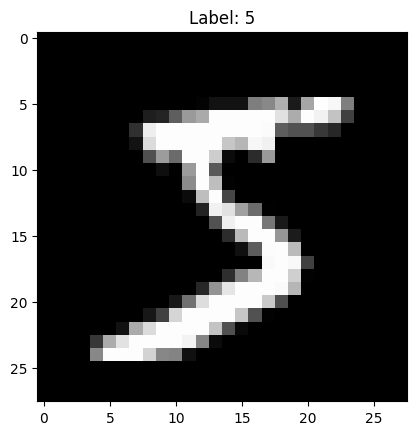

<class 'numpy.ndarray'>
(1, 28, 28)
Class: 4


In [9]:
# The following line was necessary to import the MNIST images.
# Source: https://stackoverflow.com/questions/78668638/unable-to-load-mnist-data-set-due-to-ssl-error-in-keras-load-data-function
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

# Libraries to include data and reading it in as images and arrays
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# Load MNIST dataset as images
train_dataset_as_images = dsets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset_as_images = dsets.MNIST(root='./data', train=False, download=True, transform=None)

# Load the MNIST dataset as arrays
train_dataset_as_arrays = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset_as_arrays = [(t.numpy(), c) for t,c in train_dataset_as_arrays]
test_dataset_as_arrays = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_dataset_as_arrays = [(t.numpy(), c) for t,c in test_dataset_as_arrays]

# The population is way too big for this notebook to handle in a reasonable amount of time - we'll scale down
train_indices = range(len(train_dataset_as_arrays))
train_sample_indices = random.sample(population=train_indices, k=int(0.01*len(train_indices)))
test_indicies = range(len(test_dataset_as_arrays))
test_sample_indices = random.sample(population=test_indicies, k=int(0.01*len(test_indicies)))
train_dataset_as_arrays = [train_dataset_as_arrays[i] for i in train_sample_indices]
test_dataset_as_arrays = [test_dataset_as_arrays[i] for i in test_sample_indices]
print(f"Train Population Size: {len(train_dataset_as_arrays)}")
print(f"Test Population Size: {len(test_dataset_as_arrays)}")

# Display the first sample image
first_image, first_label = train_dataset_as_images[0]
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {first_label}")
plt.show()

# Display said image as an array
first_image_array, first_label = train_dataset_as_arrays[0]
print(type(first_image_array))
print(first_image_array.shape)
print(f"Class: {first_label}")

In [10]:
import numpy as np

# We need a way to discretize each pixel value for an image
def discretize_images(dataset: list[tuple[np.ndarray, int]], continuous_splits: int=2) -> list[Observation]:
    """Given a list of images - represented as arrays - discretize each pixel value to turn this list of images into a list of Observations

    Args:
        dataset (list[tuple[np.ndarray, int]]): list of images with their classifications
        continuous_splits (int): the number of different classes we partition out of float-valued pixel values - by default 2 which one can generally think of as either filled in or not filled in (opaque/transparent)

    Returns:
        list[Observation]: discretized list of images with their classifications
    """
    images = [image_class_pair[0].reshape(-1).tolist() for image_class_pair in dataset]
    classes = [image_class_pair[1] for image_class_pair in dataset]
    
    # Before we continue, here's a helper function for discretizing a float
    def discretize(v: float, min_v: float, max_v: float) -> int:
        """Helper method to determine the discretized value of a float given the min and max

        Args:
            v (float): float value
            min_v (float): min float value
            max_v (float): max float value

        Returns:
            int: discretized value of input float v
        """
        if max_v == min_v: # A lot of the pixels have value 0.0 for ALL handwritten digit images
            return 0
        normalized_v = (v - min_v) / (max_v - min_v)
        discrete_class_width = 1 / continuous_splits
        return int(normalized_v / discrete_class_width)
    
    num_pixels = len(images[0])
    possible_discretized_pixel_values = {}
    discretized_pixel_values = [[] for _ in range(num_pixels)]
    # Find max and min pixel values for each pixel, then for all values, normalize and then discretize them
    for i in range(num_pixels):
        min_pixel_value = float('inf')
        max_pixel_value = float('-inf')
        possible_discretized_pixel_values[i] = set()
        for image in images:
            pixel_value = image[i]
            min_pixel_value = min(min_pixel_value, pixel_value)
            max_pixel_value = max(max_pixel_value, pixel_value)
        for image in images:
            pixel_value = image[i]
            discretized_pixel_value = discretize(v=pixel_value, min_v=min_pixel_value, max_v=max_pixel_value)
            possible_discretized_pixel_values[i].add(discretized_pixel_value)
            discretized_pixel_values[i].append(discretized_pixel_value)
    
    image_observations = []
    attributes = [Attribute(values=possible_discretized_pixel_values[i]) for i in possible_discretized_pixel_values.keys()]
    for j in range(len(images)):
        pixel_values = [discretized_pixel_values[i][j] for i in range(num_pixels)]
        image_observations.append(Observation(classification=classes[j], attributes=attributes, values=pixel_values))
    
    return image_observations

In [ ]:
# First we will discretize all observations
all_observations = discretize_images(dataset=train_dataset_as_arrays + test_dataset_as_arrays)

# Next we will create a decision tree based on the training subset and see the trainig results
training_observations = all_observations[:len(train_dataset_as_arrays)]
decision_tree = DecisionTree(observations=training_observations, gini_index=True)
decision_tree.display_results(population=training_observations, population_label="Train")

# Following that, we will see how performance looks on the testing population
testing_observations = all_observations[len(train_dataset_as_arrays):]
decision_tree.display_results(population=testing_observations, population_label="Test")

Train Accuracy: 100.0%
Test Accuracy: 47.0%


In [13]:
decision_tree = DecisionTree(observations=training_observations)
decision_tree.display_results(population=training_observations, population_label="Train")
decision_tree.display_results(population=testing_observations, population_label="Test")

KeyboardInterrupt: 